In [1]:
import os
import sys
import batman
import numpy as np
from astropy import units
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
from cos_transits import TransitsWithCOS

In [2]:
url = 'https://coolors.co/palette/590d22-800f2f-a4133c-c9184a-ff4d6d-ff758f-ff8fa3-ffb3c1-ffccd5'
colors = np.array(['#{0}'.format(i) for i in url.split('/')[-1].split('-')])

## data set up

Predicted transit times from John Livingston's TTV model (units of MJD)

In [3]:
predicted_Tc = np.array([2459571.90279, 2459596.65227, 2459613.15229, 2459786.41361])-2400000.5  #MJD
predicted_Tc_err = [0.00280, 0.00282, 0.00282, 0.00272]  # days

predicted_ingress = Time(['2021-12-23 07:13', '2022-01-17 01:12', 
                          '2022-02-02 13:12', '2022-07-25 19:28']).mjd
predicted_egress  = Time(['2021-12-23 12:06', '2022-01-17 06:06', 
                         '2022-02-02 18:06', '2022-07-26 00:22']).mjd

In [4]:
data_a = np.load('V1298_Tau/data_a_2min_interp.npy', allow_pickle=True).item()
data_b = np.load('V1298_Tau/data_b_2min_interp.npy', allow_pickle=True).item()

In [5]:
visits = np.zeros(len(data_a['time']))
inds = np.where(np.diff(data_a['time']) > 1)[0]+1
inds = np.sort(np.append([0, len(data_a['time'])], inds))
for i in range(len(inds)-1):
    visits[inds[i]:inds[i+1]] = i+1

In [6]:
twc_a = TransitsWithCOS(data_a['wavelength'], data_a['flux'], data_a['flux_err'],
                        data_a['time'], predicted_Tc, predicted_ingress, 
                        predicted_egress, interpolate=True)
twc_b = TransitsWithCOS(data_b['wavelength'], data_b['flux'], data_b['flux_err'],
                        data_b['time'], predicted_Tc, predicted_ingress, 
                        predicted_egress, interpolate=True)

In [7]:
twc_a.define_in_vs_out(inbounds=[-0.1, 0.1], outbounds=[0.15, 0.35])
twc_a.load_line_table('.', 'v1298tau_linelist.txt')

twc_b.define_in_vs_out(inbounds=[-0.1, 0.1], outbounds=[0.15, 0.35])
twc_b.load_line_table('.', 'v1298tau_linelist.txt')

## Signal to Noise of some lines

6.319843620399563

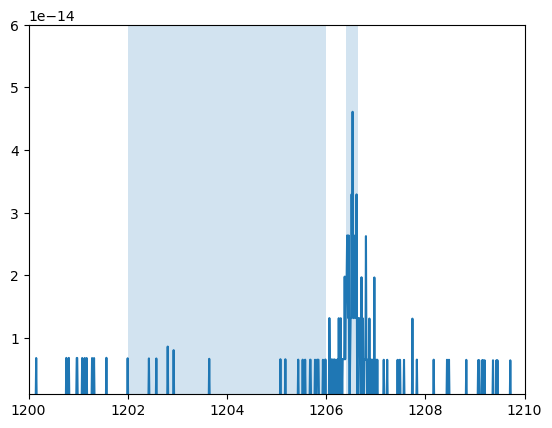

In [62]:
plt.plot(twc_b.wavelength[100], twc_b.flux[100])
plt.xlim(1200,1210)
x1, x2 = 1206.4, 1206.65
x3, x4 = 1202, 1206
plt.axvspan(x1, x2, alpha=0.2)
plt.axvspan(x3, x4, alpha=0.2)
plt.ylim(1e-15, 6e-14)
signal = np.nanmax(twc_b.flux[100][(twc_b.wavelength[100]>x1) & (twc_b.wavelength[100]<x2)])
noise = np.nanmedian(np.abs(twc_b.flux[100][(twc_b.wavelength[100]>x3) & (twc_b.wavelength[100]<x4)]))
(signal-noise)/np.sqrt(noise)*1e6

4.035055459465775e-06

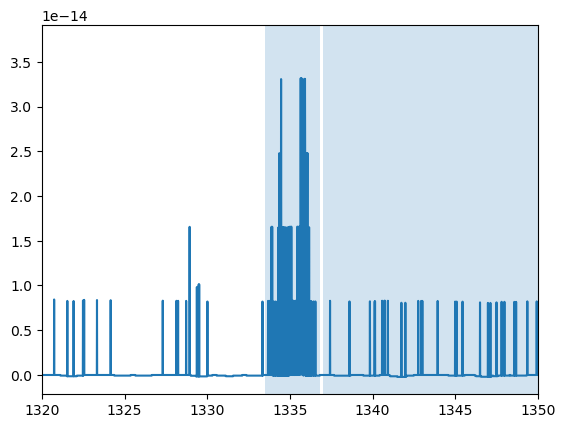

In [58]:
plt.plot(twc_a.wavelength[100], twc_a.flux[100])
plt.xlim(1320, 1350)
x1, x2 = 1333.5, 1336.8
x3, x4 = 1337, 1350
plt.axvspan(x1, x2, alpha=0.2)
plt.axvspan(x3, x4, alpha=0.2)
signal = np.nanmax(twc_a.flux[100][(twc_a.wavelength[100]>x1) & (twc_a.wavelength[100]<x2)])
noise = np.nanmedian(np.abs(twc_a.flux[100][(twc_a.wavelength[100]>x3) & (twc_a.wavelength[100]<x4)]))
(signal-noise)/np.sqrt(noise)

## Light curve figures

In [8]:
%load_ext autoreload
%autoreload 2
from cos_transits import TransitsWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
meanflux_a = np.nansum(twc_a.flux, axis=0)
meanflux_b = np.nansum(twc_b.flux, axis=0)

In [ ]:
ions = ['CII_combined', 'SiIV_combined', 'SiIII_3', 'SiIII_1',  'NV_combined']

meanflux_a = np.nansum(twc_a.flux, axis=0)

for ion in ions[:3]:
    wave_c = twc_a.line_table[twc_a.line_table['ion']==ion]['wave_c']
    vmin = twc_a.line_table[twc_a.line_table['ion']==ion]['vmin']
    vmax = twc_a.line_table[twc_a.line_table['ion']==ion]['vmax']
    estart = twc_a.line_table[twc_a.line_table['ion']==ion]['exclude_start']
    estop = twc_a.line_table[twc_a.line_table['ion']==ion]['exclude_stop']
    
    v, _ = twc_a.to_velocity(twc_a.wavelength[0], wave_c)
    
    if estart == 0:
        q = ((v.value >= vmin) & (v.value <= vmax))
    else:
        q = (((v.value>=vmin) & (v.value<=estart)) |
              ((v.value>=estop) & (v.value<vmax)) )
    
    plt.plot(v[q], meanflux_a[q])
    
    if ion == 'SiIV_combined':
        plt.vlines([-700, 720], 0, 3e-12, color='k', linestyle='--')
    
    plt.show()
    
for ion in ions[3:]:
    wave_c = twc_b.line_table[twc_b.line_table['ion']==ion]['wave_c']
    vmin = twc_b.line_table[twc_b.line_table['ion']==ion]['vmin']
    vmax = twc_b.line_table[twc_b.line_table['ion']==ion]['vmax']
    estart = twc_b.line_table[twc_b.line_table['ion']==ion]['exclude_start']
    estop = twc_b.line_table[twc_b.line_table['ion']==ion]['exclude_stop']
    
    v, _ = twc_b.to_velocity(twc_b.wavelength[0], wave_c)
    
    if estart == 0:
        q = ((v.value >= vmin) & (v.value <= vmax))
    else:
        q = (((v.value>=vmin) & (v.value<=estart)) |
              ((v.value>=estop) & (v.value<vmax)) )
    
    plt.plot(v[q], meanflux_b[q])
    
    if ion == 'NV_combined':
        plt.vlines([-300, 300], 0, 3e-12, color='k', linestyle='--')
    
    plt.show()

# Light Curves

### BATMAN transit fit

In [102]:
def fit_transit(t, rp):
    params = batman.TransitParams()
    params.t0 = 0.                       #time of inferior conjunction
    params.per = 8.2438                  #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = 13.19                     #semi-major axis (in units of stellar radii)
    params.inc = 87.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
    
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
    return flux

### Generating the light curves

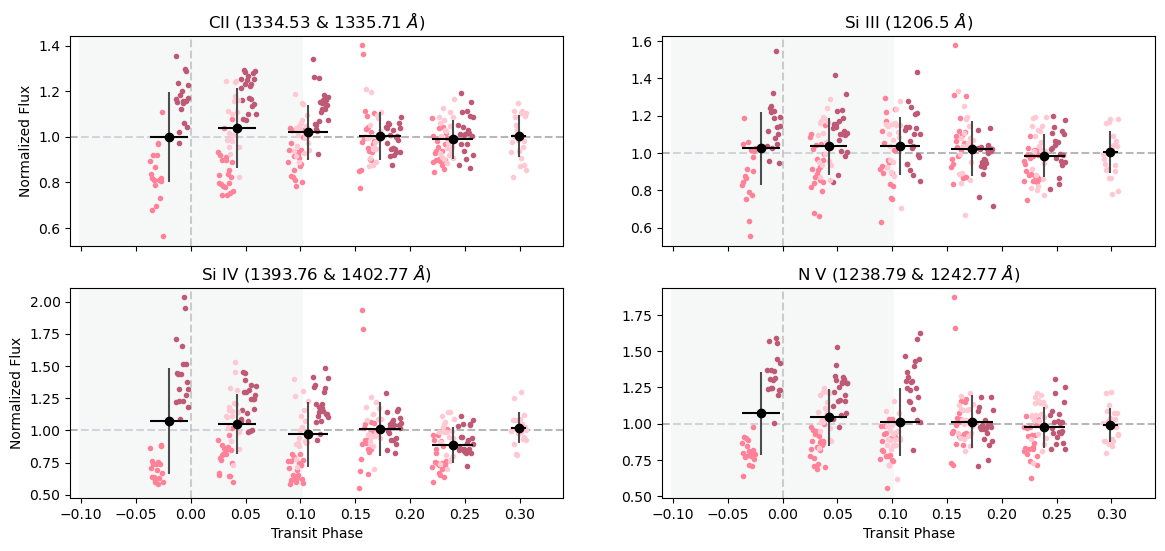

In [145]:
ions = ['CII_combined', 'SiIII_1', 'SiIV_combined', 'NV_combined']
titles = [r'CII (1334.53 & 1335.71 $\AA$)', r'Si III (1206.5 $\AA$)', 
          r'Si IV (1393.76 & 1402.77 $\AA$)', r'N V (1238.79 & 1242.77 $\AA$)']

fig, axes = plt.subplots(figsize=(14,6), ncols=2, nrows=int(len(ions)/2), 
                         sharex=True)
fig.set_facecolor('w')
axes = axes.reshape(-1)

visits = [2,3,4]

for i in range(len(ions)):
    
    wave_c = twc_a.line_table[twc_a.line_table['ion']==ions[i]]['wave_c']
    
    if (wave_c >= twc_a.wavelength[0][0]) & (wave_c <= twc_a.wavelength[0][-1]):
        
        tab_temp, avg_temp = twc_a.plot_lc(ion=ions[i], 
                                           colors=colors[np.array([2, 4, 7], dtype=int)],
                                           ax=axes[i], detrend=True, 
                                           visits=visits,
                                           pldict={'marker':'.', 'linestyle':'', 'zorder':1,
                                                   'rasterized':True})
    else:
        tab_temp, avg_temp = twc_b.plot_lc(ion=ions[i], 
                                           colors=colors[np.array([2, 4, 7], dtype=int)],
                                           ax=axes[i], detrend=True, 
                                           visits=visits,
                                           pldict={'marker':'.', 'linestyle':'', 'zorder':1,
                                                   'rasterized':True})
    if i == 0:
        all_lcs = tab_temp
        avg_lcs = avg_temp
        
    else:
        for colname in tab_temp.colnames:
            all_lcs[colname] = tab_temp[colname]
        for colname in avg_temp.colnames:
            avg_lcs[colname] = avg_temp[colname]
        
    axes[i].set_title(titles[i])
    axes[i].axhline(1, color='k', linestyle='--', alpha=0.4, zorder=0)
    axes[i].axvline(0, color='k', linestyle='--', alpha=0.5, zorder=0)

    axes[i].axvspan(-0.2, 0.35, zorder=2,
                    color='#ffffff', lw=0, alpha=0.3)

    axes[i].axvspan(predicted_ingress[1]-predicted_Tc[1],
                    predicted_egress[1]-predicted_Tc[1], 
                    color='#e9ecef', lw=0, alpha=0.5, zorder=0)

plt.xlim(-0.11, 0.34)
for i in [0, 2]:
    axes[i].set_ylabel('Normalized Flux')
axes[-2].set_xlabel('Transit Phase')
axes[-1].set_xlabel('Transit Phase')
plt.savefig('v1298tauc_lightcurves.png', dpi=300, 
            bbox_inches='tight')

<Quantity 4.27100557 jupiterRad>

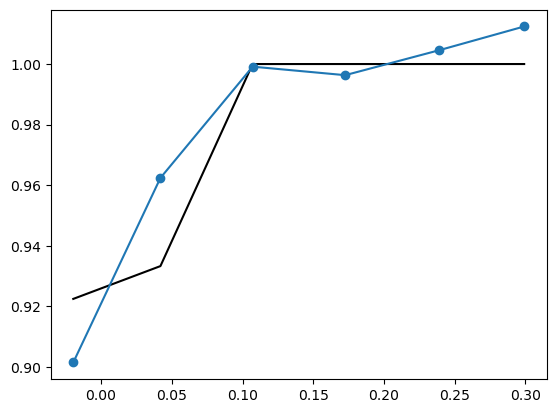

In [177]:
res = curve_fit(fit_transit, avg_lcs['CII_combined_phase'],
                avg_lcs['CII_combined_flux']-avg_lcs['CII_combined_flux_err']+0.1, 
                p0=[0.1])

bt = fit_transit(avg_lcs['CII_combined_phase'], res[0][0])
plt.plot(avg_lcs['CII_combined_phase'], bt, 'k')

plt.errorbar(avg_lcs['CII_combined_phase'],
             (avg_lcs['CII_combined_flux']-avg_lcs['CII_combined_flux_err'])+0.1, 
             marker='o')

(1.33*0.33*units.Rsun).to(units.Rjup)

<Quantity 6.34179615 jupiterRad>

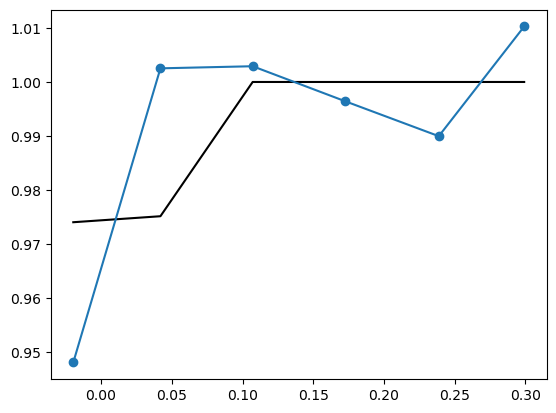

In [182]:
ylow = avg_lcs['SiIII_1_flux']-avg_lcs['SiIII_1_flux_err']+0.12

res = curve_fit(fit_transit, avg_lcs['SiIII_1_phase'],
                ylow,
                p0=[0.1])

bt = fit_transit(avg_lcs['SiIII_1_phase'], res[0][0])
plt.plot(avg_lcs['SiIII_1_phase'], bt, 'k')

plt.errorbar(avg_lcs['SiIII_1_phase'],
             ylow, 
             marker='o')

(1.33*0.49*units.Rsun).to(units.Rjup)

In [185]:
avg_lcs.write('v1298tauc_avg_lc.csv', format='csv', overwrite=True)
all_lcs.write('v1298tauc_all_lcs.csv', format='csv', overwrite=True)

# Line Profiles

In [ ]:
twc_a.plot_line_profiles('SiIV_2', [2,3,4], colors[np.array([2, 4, 7], dtype=int)],
                         fn='SiIV_2.png')

# Appendix
## interpolate wavelength & flux onto the same grid

In [ ]:
data_a = np.load('V1298_Tau/data_a_2min.npy', allow_pickle=True).item()
data_b = np.load('V1298_Tau/data_b_2min.npy', allow_pickle=True).item()

In [ ]:
delta = np.diff(data_a['wavelength'][0])
wave_soln = np.copy(data_a['wavelength'][0])

interp_flux = np.zeros(data_a['flux'].shape)
interp_errs = np.zeros(data_a['flux'].shape)

for i in range(len(data_a['wavelength'])):
    
    if visits[i] == 4:
        offset = -0.235
    else:
        offset = 0.0
    
    for j in range(len(wave_soln)):

        try:
            inds = np.where((data_a['wavelength'][i]+offset>wave_soln[j]-delta[0]/2.0) & 
                            (data_a['wavelength'][i]+offset<wave_soln[j]+delta[0]/2.0))[0][0]

            interp_flux[i][j] = data_a['flux'][i][inds]
            interp_errs[i][j] = data_a['flux_err'][i][inds]
            
        except IndexError:
            interp_flux[i][j] = np.nan
            
np.save('V1298_Tau/data_a_2min_interp.npy', {'wavelength': data_a['wavelength'],
                                             'flux':interp_flux,
                                             'flux_err':interp_errs,
                                              'time':data_a['time']})

In [ ]:
delta = np.diff(data_b['wavelength'][0])
wave_soln = np.copy(data_b['wavelength'][0])

interp_wave = np.zeros(data_b['wavelength'].shape)
interp_flux = np.zeros(data_b['flux'].shape)
interp_errs = np.zeros(data_b['flux'].shape)

for i in range(len(data_b['wavelength'])):
    
    if visits[i] == 4:
        offset = -0.235
    else:
        offset = 0.0
    
    for j in range(len(wave_soln)):

        try:

            inds = np.where((data_b['wavelength'][i]+offset>wave_soln[j]-delta[0]/2.0) & 
                            (data_b['wavelength'][i]+offset<wave_soln[j]+delta[0]/2.0))[0][0]

            interp_flux[i][j] = data_b['flux'][i][inds]
            interp_errs[i][j] = data_b['flux_err'][i][inds]
            
        except IndexError:
            interp_flux[i][j] = np.nan
            
np.save('V1298_Tau/data_b_2min_interp.npy', {'wavelength': data_b['wavelength'],
                                             'flux':interp_flux,
                                             'flux_err':interp_errs,
                                             'time':data_b['time']})